# 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.data.load_dataset import load_epacems, load_epa_crosswalk
from src.features.build_features import uptime_events, calc_distance_from_downtime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## CEMS Processing

In [3]:
# all states, 1 year
cols = ['plant_id_eia', 'unitid', 'operating_datetime_utc',
        'operating_time_hours', 'gross_load_mw', 'steam_load_1000_lbs',
        'heat_content_mmbtu', 'unit_id_epa',
       ]
cems = load_epacems(states=None, years=[2019], columns=cols, engine='pandas')

In [4]:
%%time
idx = pd.IndexSlice
cems.sort_values(by=['unit_id_epa', 'operating_datetime_utc'], inplace=True)
cems.set_index(['unit_id_epa', 'operating_datetime_utc'], drop=False, inplace=True)#, verify_integrity=True)

CPU times: user 17.3 s, sys: 4.6 s, total: 21.9 s
Wall time: 22.2 s


### Calculate ramps and distance from downtime

In [5]:
%time calc_distance_from_downtime(cems) # in place
print('')

CPU times: user 20.3 s, sys: 4.14 s, total: 24.4 s
Wall time: 24.1 s



In [6]:
units = cems.groupby(level="unit_id_epa")
# ramp rate: MW / hour
cems['ramp_rate'] = units["gross_load_mw"].transform(lambda x: x.diff())

In [7]:
cems.head()

plant_id_eia unitid  \
unit_id_epa operating_datetime_utc                           
1           2019-01-01 06:00:00+00:00             3      1   
            2019-01-01 07:00:00+00:00             3      1   
            2019-01-01 08:00:00+00:00             3      1   
            2019-01-01 09:00:00+00:00             3      1   
            2019-01-01 10:00:00+00:00             3      1   

                                         operating_datetime_utc  \
unit_id_epa operating_datetime_utc                                
1           2019-01-01 06:00:00+00:00 2019-01-01 06:00:00+00:00   
            2019-01-01 07:00:00+00:00 2019-01-01 07:00:00+00:00   
            2019-01-01 08:00:00+00:00 2019-01-01 08:00:00+00:00   
            2019-01-01 09:00:00+00:00 2019-01-01 09:00:00+00:00   
            2019-01-01 10:00:00+00:00 2019-01-01 10:00:00+00:00   

                                       operating_time_hours  gross_load_mw  \
unit_id_epa operating_datetime_utc                                           
1           2019-01-01 06:00:00+00:00                   0.0            0.0   
            2019-01-01 07:00:00+00:00                   0.0            0.0   
            2019-01-01 08:00:00+00:00                   0.0            0.0   
            2019-01-01 09:00:00+00:00                   0.0            0.0   
            2019-01-01 10:00:00+00:00                   0.0            0.0   

                                       steam_load_1000_lbs  \
unit_id_epa operating_datetime_utc                           
1           2019-01-01 06:00:00+00:00                  NaN   
            2019-01-01 07:00:00+00:00                  NaN   
            2019-01-01 08:00:00+00:00                  NaN   
            2019-01-01 09:00:00+00:00                  NaN   
            2019-01-01 10:00:00+00:00                  NaN   

                                       heat_content_mmbtu  unit_id_epa  \
unit_id_epa operating_datetime_utc                                       
1           2019-01-01 06:00:00+00:00                 0.0            1   
            2019-01-01 07:00:00+00:00                 0.0            1   
            2019-01-01 08:00:00+00:00                 0.0            1   
            2019-01-01 09:00:00+00:00                 0.0            1   
            2019-01-01 10:00:00+00:00                 0.0            1   

                                       hours_from_startup  hours_to_shutdown  \
unit_id_epa operating_datetime_utc                                             
1           2019-01-01 06:00:00+00:00                24.0             1467.0   
            2019-01-01 07:00:00+00:00                25.0             1466.0   
            2019-01-01 08:00:00+00:00                26.0             1465.0   
            2019-01-01 09:00:00+00:00                27.0             1464.0   
            2019-01-01 10:00:00+00:00                28.0             1463.0   

                                       ramp_rate  
unit_id_epa operating_datetime_utc                
1           2019-01-01 06:00:00+00:00        NaN  
            2019-01-01 07:00:00+00:00        0.0  
            2019-01-01 08:00:00+00:00        0.0  
            2019-01-01 09:00:00+00:00        0.0  
            2019-01-01 10:00:00+00:00        0.0

In [8]:
cems['hours_distance'] = (cems[['hours_from_startup', 'hours_to_shutdown']].min(axis=1))

In [9]:
cems['nearest_to_startup'] = cems['hours_from_startup'] < cems['hours_to_shutdown']
# randomly allocate midpoints
rng = np.random.default_rng(seed=42)
rand_midpoints = (cems['hours_from_startup'] == cems['hours_to_shutdown']) & rng.choice(np.array([True, False]), size=len(cems))
cems.loc[rand_midpoints, 'is_startup'] = True
del rand_midpoints

## Aggregate

### Max ramp rates

In [10]:
cems['hours_distance_clipped'] = cems['hours_distance'].clip(upper=10) # threshold

In [11]:
max_ramps = (cems.drop(columns=['unit_id_epa']) # resolve ambiguity between index and col with same name
             .groupby(['unit_id_epa', 'hours_distance_clipped', 'nearest_to_startup'])['ramp_rate']
             .agg(['max', 'min'])
             .add_suffix('_ramp_rate')
            )

In [12]:
max_ramps['abs_max_ramps'] = max_ramps[['max_ramp_rate', 'min_ramp_rate']].abs().max(axis=1)

### Other aggregates
#### Per-unit metrics

In [13]:
per_unit_aggs = cems.groupby(level='unit_id_epa')['gross_load_mw'].agg(['max', 'count', 'sum']).add_suffix('_load')

In [14]:
per_unit_aggs['utilization'] = cems['gross_load_mw'].gt(0).groupby(level='unit_id_epa').mean()
per_unit_aggs['capacity_factor'] = per_unit_aggs['sum_load'].div(per_unit_aggs['max_load'] * per_unit_aggs['count_load'])

#### uptime event analysis
Summary stats about the distribution of uptime events can help distinguish different types of plant operation

In [15]:
%time events = uptime_events(cems)

CPU times: user 27.9 s, sys: 2.42 s, total: 30.3 s
Wall time: 30.4 s


In [16]:
events.sample(3)

,,startup,shutdown,duration_hours
unit_id_epa,event,,,
432,150,2019-11-24 12:00:00+00:00,2019-11-25 06:00:00+00:00,18.0
89579,56,2019-08-21 18:00:00+00:00,2019-08-22 06:00:00+00:00,12.0
1771,244,2019-10-07 08:00:00+00:00,2019-10-08 05:00:00+00:00,21.0


In [17]:
uptime_aggs = (events['duration_hours'].groupby(level='unit_id_epa').agg(['count', 'mean', 'std'])
             .rename(columns={
                 'count': 'n_uptime_events',
                 'mean': 'mean_uptime_duration',
                 'std': 'std_uptime_duration'}
                    )
            )

## Join other info

### Join other aggregates

In [18]:
max_ramps = (max_ramps
             .join(per_unit_aggs, on='unit_id_epa')
             .join(uptime_aggs, on='unit_id_epa')
            )

In [19]:
del per_unit_aggs, uptime_aggs

### Join Crosswalk

#### Prep: bring in surrogate key

In [20]:
key_map = cems[['plant_id_eia', 'unitid', 'unit_id_epa']].reset_index(drop=True).drop_duplicates()

In [21]:
crosswalk = load_epa_crosswalk()

In [22]:
crosswalk = crosswalk.merge(key_map,
                            left_on=['CAMD_PLANT_ID', 'CAMD_UNIT_ID'],
                            right_on=['plant_id_eia', 'unitid'],
                            how='right',
                            validate='many_to_one' # checks if right (key_map) is unique
                           )

18 failed matches

In [23]:
crosswalk.loc[crosswalk.isna().mean(axis=1) > 0.75, ['plant_id_eia', 'unitid', 'unit_id_epa', 'CAMD_PLANT_ID', 'CAMD_UNIT_ID']]

,plant_id_eia,unitid,unit_id_epa,CAMD_PLANT_ID,CAMD_UNIT_ID
4104,1599,3,88425,NaN,NaN
4266,56104,CT-1,89427,NaN,NaN
5493,568,BHB5,91155,NaN,NaN
5533,61035,01,91213,NaN,NaN
5537,61242,CT1,91228,NaN,NaN
5538,61242,CT2,91229,NaN,NaN
5545,59882,J4,91232,NaN,NaN
5546,59882,J5,91233,NaN,NaN
5591,116,GT3,91277,NaN,NaN
5592,116,GT4,91278,NaN,NaN


In [24]:
subset = ['CAMD_FACILITY_NAME', 'CAMD_PLANT_ID',
       'CAMD_UNIT_ID', 'CAMD_GENERATOR_ID', 'CAMD_NAMEPLATE_CAPACITY', 'EIA_PLANT_NAME', 'EIA_PLANT_ID',
       'EIA_GENERATOR_ID', 'EIA_NAMEPLATE_CAPACITY', 'EIA_BOILER_ID',
       'EIA_UNIT_TYPE', 'EIA_FUEL_TYPE',]

In [25]:
crosswalk.loc[crosswalk['EIA_PLANT_ID'] == 116, subset]

,CAMD_FACILITY_NAME,CAMD_PLANT_ID,CAMD_UNIT_ID,CAMD_GENERATOR_ID,CAMD_NAMEPLATE_CAPACITY,EIA_PLANT_NAME,EIA_PLANT_ID,EIA_GENERATOR_ID,EIA_NAMEPLATE_CAPACITY,EIA_BOILER_ID,EIA_UNIT_TYPE,EIA_FUEL_TYPE
47,Ocotillo Power Plant,116.0,1,1,113.6,Ocotillo,116.0,1,113.6,1,ST,NG
48,Ocotillo Power Plant,116.0,2,2,113.6,Ocotillo,116.0,2,113.6,2,ST,NG


#### Aggregate combustor/generator types
About a third of combustor/generator relationships are not one-to-one, meaning multiple unit and fuel types can be involved. **For a fast first analysis, I resolved ambiguity in categories by labeling each generator with the most frequent category.** The most frequent type may be different from the highest capacity or most energy produced, etc.

It shouldn't be too hard to refine these aggregations with a more appropriate metric. While handling that, I can also aggregate nameplate capacity.

In [26]:
subset = ['CAMD_FUEL_TYPE', 'EIA_FUEL_TYPE', 'EIA_UNIT_TYPE']
generator_aggs = (crosswalk
                  .fillna(dict.fromkeys(subset, 'NaN')) # otherwise pd.Series.Mode returns array([])
                  .groupby(['CAMD_PLANT_ID', 'CAMD_GENERATOR_ID'])[subset]
                  .agg(pd.Series.mode)
                  .add_prefix('agg_')
                  .reset_index()
                 )

In [27]:
generator_aggs.shape

(4496, 5)

In [28]:
crosswalk = crosswalk.merge(generator_aggs, on=['CAMD_PLANT_ID', 'CAMD_GENERATOR_ID'], how='left')

#### Mark one-to-one units

In [29]:
# calculate cardinality of combustor relationships
crosswalk = crosswalk.merge(crosswalk.groupby(['CAMD_PLANT_ID', 'CAMD_UNIT_ID'],
                                              as_index=False)['CAMD_GENERATOR_ID']
                            .size()
                            .rename(columns={'size': 'has_single_edge_from_combust'}),
                            on=['CAMD_PLANT_ID', 'CAMD_UNIT_ID'],
                            how='left'
                           )
crosswalk['has_single_edge_from_combust'] = crosswalk['has_single_edge_from_combust'].eq(1)

In [30]:
# calculate cardinality of generator relationships
crosswalk = crosswalk.merge(crosswalk.groupby(['CAMD_PLANT_ID', 'CAMD_GENERATOR_ID'],
                                              as_index=False)['CAMD_UNIT_ID']
                            .size()
                            .rename(columns={'size': 'has_single_edge_from_gen'}),
                            on=['CAMD_PLANT_ID', 'CAMD_GENERATOR_ID'],
                            how='left'
                           )
crosswalk['has_single_edge_from_gen'] = crosswalk['has_single_edge_from_gen'].eq(1)

In [31]:
crosswalk = crosswalk.merge(crosswalk.groupby(['CAMD_PLANT_ID', 'CAMD_UNIT_ID'])[['has_single_edge_from_combust',
                                                                                  'has_single_edge_from_gen']]
                            .all()
                            .all(axis='columns')
                            .rename('is_one_to_one')
                            .reset_index(),
                            on=['CAMD_PLANT_ID', 'CAMD_UNIT_ID'],
                            how='left'
                            )

In [33]:
crosswalk.shape

(5621, 42)

In [41]:
crosswalk.groupby(['CAMD_PLANT_ID', 'CAMD_UNIT_ID'])['is_one_to_one'].all().agg(['sum', 'mean'])

sum     2558.000000
mean       0.595299
Name: is_one_to_one, dtype: float64

#### Join unit info

In [34]:
subset = ['EIA_UNIT_TYPE', 'EIA_FUEL_TYPE', 'CAMD_FACILITY_NAME',
          'CAMD_PLANT_ID', 'CAMD_GENERATOR_ID', 'CAMD_NAMEPLATE_CAPACITY',
          'EIA_GENERATOR_ID', 'EIA_NAMEPLATE_CAPACITY', 'EIA_BOILER_ID',
          'unit_id_epa', 'is_one_to_one', 'MATCH_TYPE_GEN',
          'agg_CAMD_FUEL_TYPE', 'agg_EIA_FUEL_TYPE', 'agg_EIA_UNIT_TYPE'
         ]

In [35]:
max_ramps = max_ramps.join(crosswalk[subset].set_index('unit_id_epa'), on='unit_id_epa')

In [36]:
#subset = ['CAMD_FUEL_TYPE', 'unit_id_epa']
#max_ramps = max_ramps.join(crosswalk[subset].drop_duplicates().set_index('unit_id_epa'), on='unit_id_epa')

#### Drop non-exporting industrial CHP
per EPA docs, `Manual CAMD Excluded` indicates industial co-generation plants that don't export to the grid.

In [37]:
max_ramps = max_ramps[max_ramps['MATCH_TYPE_GEN'] != 'Manual CAMD Excluded']

In [38]:
max_ramps.shape

(107929, 25)

## Analyze

In [42]:
# max ramp rates normalized by max observed load: % capacity / hour
max_ramps['max_obs_ramp_factor'] = max_ramps['abs_max_ramps'].div(max_ramps['max_load'])

In [43]:
max_ramps.columns

Index(['max_ramp_rate', 'min_ramp_rate', 'abs_max_ramps', 'max_load',
       'count_load', 'sum_load', 'utilization', 'capacity_factor',
       'n_uptime_events', 'mean_uptime_duration', 'std_uptime_duration',
       'EIA_UNIT_TYPE', 'EIA_FUEL_TYPE', 'CAMD_FACILITY_NAME', 'CAMD_PLANT_ID',
       'CAMD_GENERATOR_ID', 'CAMD_NAMEPLATE_CAPACITY', 'EIA_GENERATOR_ID',
       'EIA_NAMEPLATE_CAPACITY', 'EIA_BOILER_ID', 'is_one_to_one',
       'MATCH_TYPE_GEN', 'agg_CAMD_FUEL_TYPE', 'agg_EIA_FUEL_TYPE',
       'agg_EIA_UNIT_TYPE', 'max_obs_ramp_factor'],
      dtype='object')

### Look at one-to-one units

In [48]:
max_ramps['is_one_to_one'].isna().sum()

376

In [50]:
max_ramps[max_ramps['is_one_to_one'].isna()]['count_load'].value_counts()

6600    176
2208     68
8760     66
4416     66
Name: count_load, dtype: int64

In [57]:
non_zero_one_to_one = max_ramps[max_ramps['max_obs_ramp_factor'].gt(0)
                               & max_ramps['is_one_to_one'].fillna(False).astype(bool)].reset_index()

In [58]:
non_zero_one_to_one.shape

(39276, 29)

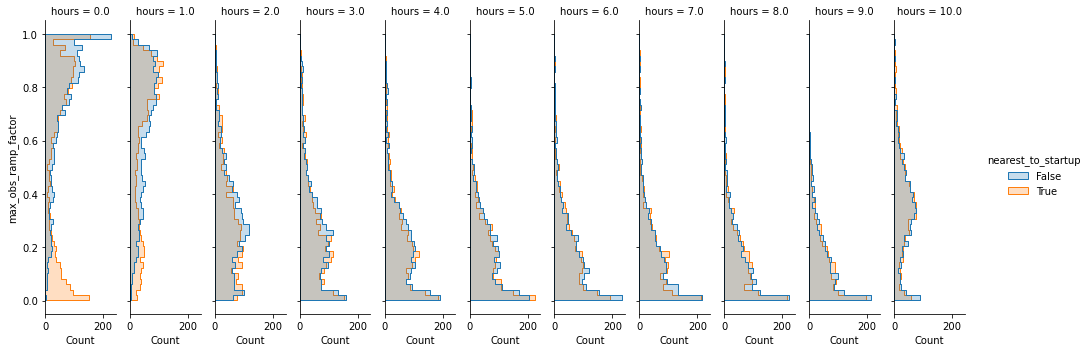

In [61]:
# Distribution of MAXIMUM ramp factor faceted by distance from startup/shutdown
# Note that the last category is 10+ hours, not =10
a = sns.displot(data=non_zero_one_to_one,
                col='hours_distance_clipped',
                y='max_obs_ramp_factor',
                hue='nearest_to_startup',
                kind="hist",
                aspect=0.25,
                element="step")
a.set_titles('hours = {col_name}')

#### By Fuel

In [63]:
non_zero_one_to_one.groupby('unit_id_epa')['agg_CAMD_FUEL_TYPE'].first().value_counts()

Pipeline Natural Gas    1533
Coal                     494
Diesel Oil               230
Natural Gas               45
Other Oil                 21
Residual Oil              21
Wood                       9
NaN                        5
Process Gas                5
Coal Refuse                3
Other Gas                  1
Name: agg_CAMD_FUEL_TYPE, dtype: int64

In [65]:
fuel_mapping = {'Pipeline Natural Gas': 'gas',
                'Diesel Oil': 'oil',
                'Natural Gas': 'gas',
                'Other Oil': 'oil',
                'Residual Oil': 'oil',
                'Process Gas': 'gas',
                'Other Gas': 'gas',
                'Coal Refuse': 'Coal',
                'Petroleum Coke': 'oil'
               }
non_zero_one_to_one['simple_CAMD_FUEL_TYPE'] = non_zero_one_to_one['agg_CAMD_FUEL_TYPE'].replace(fuel_mapping)

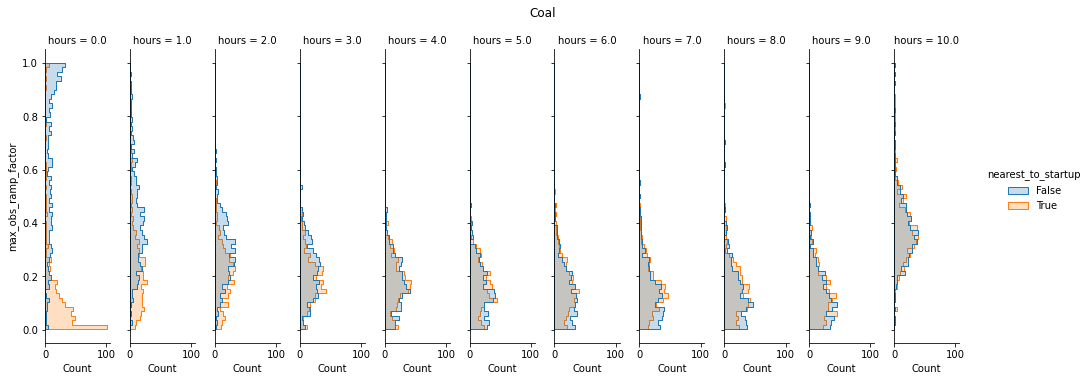

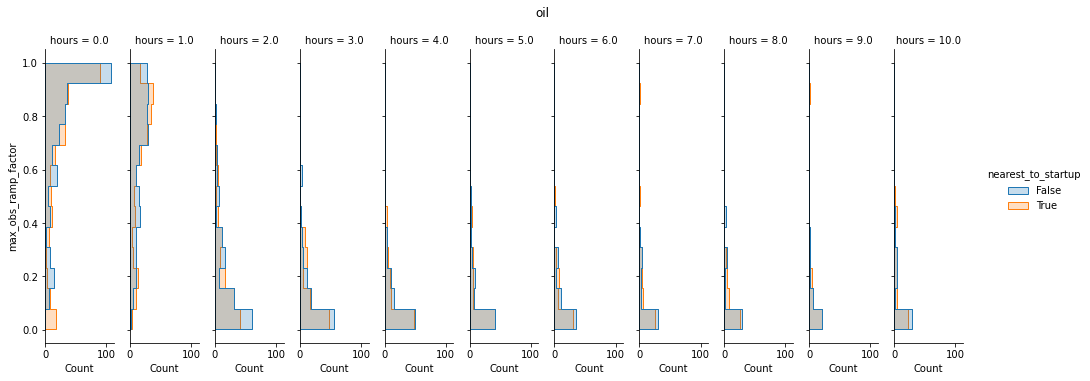

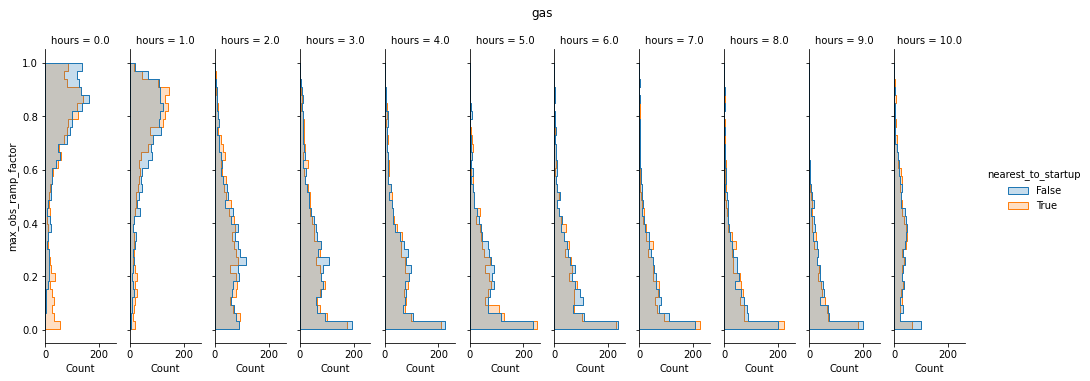

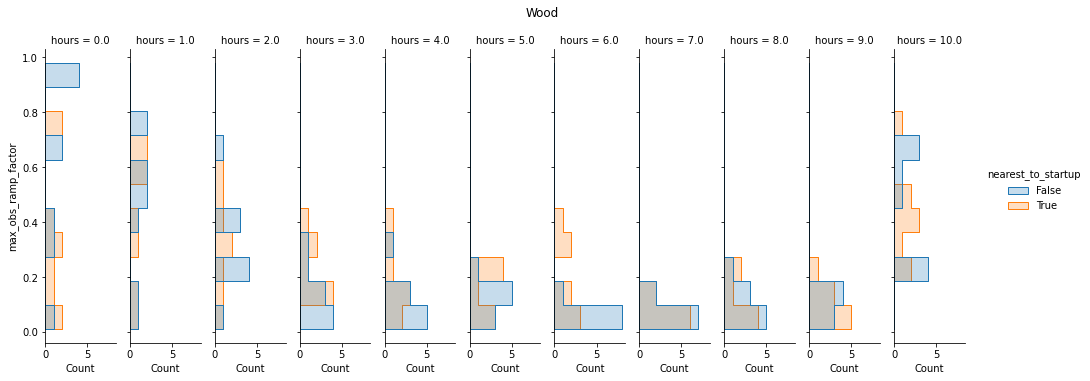

In [66]:
# Note that the last category is 10+ hours, not =10
for fuel in ['Coal', 'oil', 'gas', 'Wood']:
    sns.displot(data=non_zero_one_to_one[non_zero_one_to_one['simple_CAMD_FUEL_TYPE'] == fuel],
                col='hours_distance_clipped',
                y='max_obs_ramp_factor',
                hue='nearest_to_startup',
                kind="hist",
                aspect=0.25,
                element="step").set_titles('hours = {col_name}')
    plt.suptitle(fuel, y=1.05)
    plt.show()

#### By Generator Type

In [69]:
types = non_zero_one_to_one.groupby('unit_id_epa')['agg_EIA_UNIT_TYPE'].first().value_counts()
types

GT     1517
ST      786
CS       42
NaN      11
CT        7
IC        3
CA        1
Name: agg_EIA_UNIT_TYPE, dtype: int64

In [77]:
type_mapping = {'GT': 'Gas Turbine',
                'ST': 'Steam Turbine',
                'CS': 'Combined Cycle',
                'CT': 'Combined Cycle',
                'CA': 'Combined Cycle',
                'NaN': 'NaN',
                'IC': 'Internal Combustion'
               }
non_zero_one_to_one['simple_EIA_UNIT_TYPE'] = non_zero_one_to_one['agg_EIA_UNIT_TYPE'].map(type_mapping)

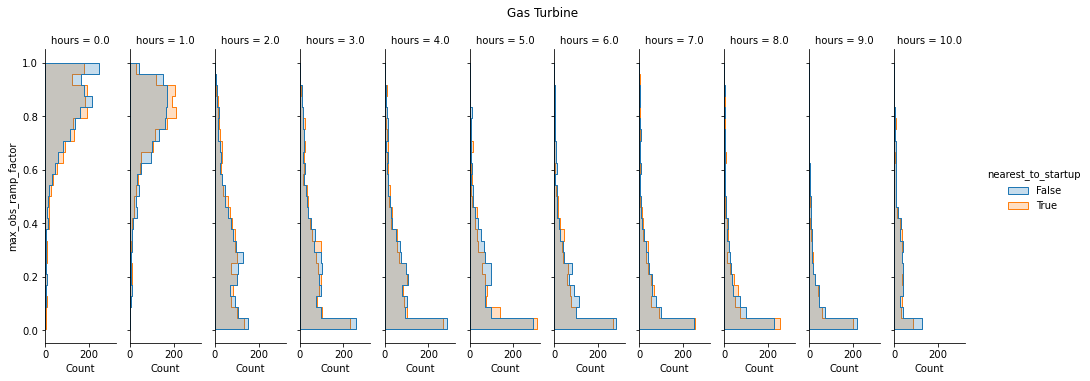

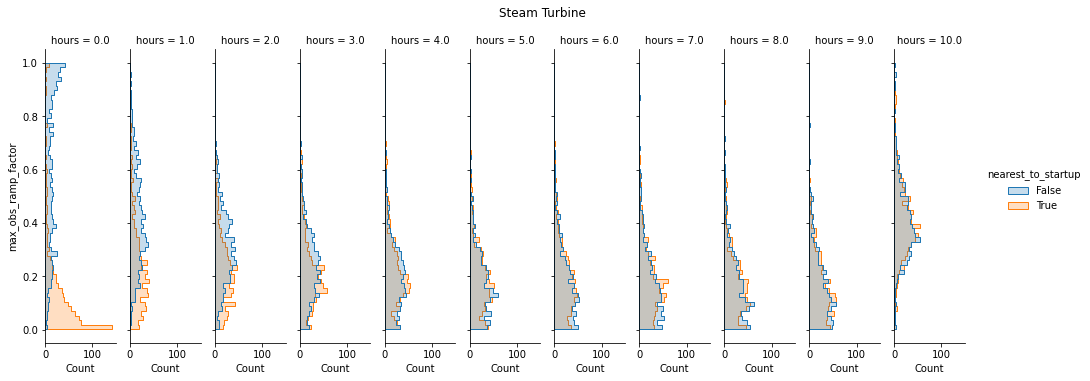

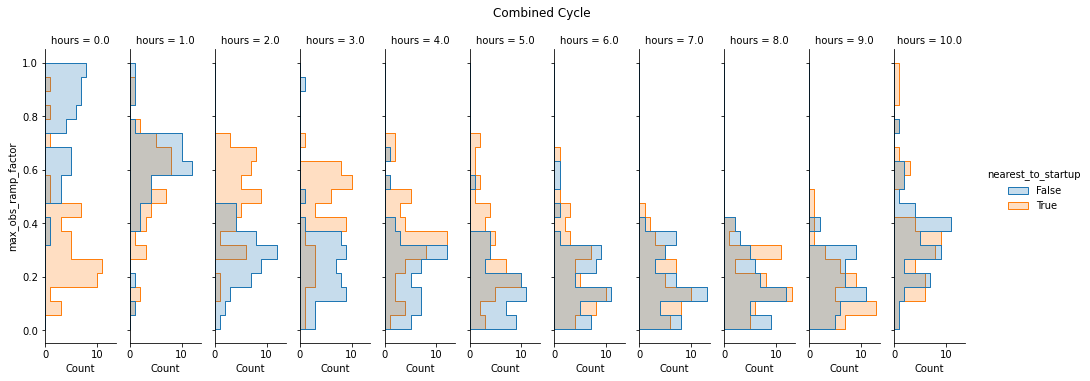

In [78]:
# Note that the last category is 10+ hours, not =10
for gen_type in ['Gas Turbine', 'Steam Turbine', 'Combined Cycle']:
    sns.displot(data=non_zero_one_to_one[non_zero_one_to_one['simple_EIA_UNIT_TYPE'] == gen_type],
                col='hours_distance_clipped',
                y='max_obs_ramp_factor',
                hue='nearest_to_startup',
                kind="hist",
                aspect=0.25,
                element="step").set_titles('hours = {col_name}')
    plt.suptitle(gen_type, y=1.05)
    plt.show()

### Aggregate to Generators
Same story as above (see "Aggregate combustor/generator types")